In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [197]:
class CapacitiveDAC:
    def __init__(self, N, Vref, C, monotonic=False):
        """
        N: Number of bits
        Vref: Reference voltage
        C: Unit capacitance
        monotonic: If True, use monotonic switching algorithm
        """
        self.N = N
        self.Vref = Vref
        self.C = C
        self.monotonic = monotonic

        # Binary-weighted capacitors: MSB first
        self.capacitors = C * np.array([2**i for i in range(N)][::-1], dtype=float)
        self.dummy_cap = self.capacitors[-1]
        self.all_caps = np.append(self.capacitors, self.dummy_cap)
        self.c_total = np.sum(self.all_caps)
        
        # Bottom-plate voltages (last is dummy)
        self.bottom_voltages = np.zeros(N + 1)
        self.q_sample = 0
        self.vout = 0
        self.num_switchings = 0

    def _update_vout(self):
        q_from_bottom = np.sum(self.all_caps * self.bottom_voltages)
        self.vout = (self.q_sample + q_from_bottom) / self.c_total
        return self.vout

    def sample(self, vin):
        # Sample phase: top node grounded, bottom plates capture charge
        self.q_sample = -vin * self.c_total
        # Initialize bottom plates to GND
        self.bottom_voltages.fill(0)
        self._update_vout()
        self.num_switchings = 0

    def convert(self):
        digital_code = np.zeros(self.N, dtype=int)
        vout_hist = []
        bottom_hist = []
        
        if self.monotonic:
            # Monotonic switching: start with all bottom=Vref
            self.bottom_voltages[:] = self.Vref
            self._update_vout()
            vout_hist.append(self.vout)
            bottom_hist.append(self.bottom_voltages.copy())
            
            for i in range(self.N):
                print(f"Step {i + 1}")
                # Trial: connect bit i to GND
                self.bottom_voltages[i] = 0
                print(f"  SW[{i}] to GND")
                self.num_switchings += 1
                v = self._update_vout()
                print(f"  Vout = {v:.2f} V")
                bit = 1 if v > 0 else 0
                print(f"  Bit = {bit}")
                if bit == 0:
                    # revert to Vref on rejection
                    self.bottom_voltages[i] = self.Vref
                    print(f"  SW[{i}] to Vref")
                    self.num_switchings += 1
                    self._update_vout()
                    print(f"  Vout = {self.vout:.2f} V")
                digital_code[i] = bit
                vout_hist.append(self.vout)
                bottom_hist.append(self.bottom_voltages.copy())
        else:
            # Standard SAR switching
            vout_hist.append(self.vout)
            bottom_hist.append(self.bottom_voltages.copy())
            for i in range(self.N):
                self.bottom_voltages[i] = self.Vref
                self.num_switchings += 1
                v = self._update_vout()
                if v < 0:
                    bit = 1
                else:
                    bit = 0
                    self.bottom_voltages[i] = 0
                    self.num_switchings += 1
                    self._update_vout()
                digital_code[i] = not bit
                vout_hist.append(self.vout)
                bottom_hist.append(self.bottom_voltages.copy())

        # Prepare step table
        rows = []
        for step, (volt, bottoms) in enumerate(zip(vout_hist, bottom_hist), start=0):
            rows.append({
                'Step': step,
                'Bottom Voltages': ','.join(f"{bv:.2f}" for bv in bottoms),
                'Vout (V)': volt,
                'Decision': digital_code[step-1] if step>0 else None
            })

        return digital_code, pd.DataFrame(rows), self.num_switchings

In [199]:
# Simulation Parameters
N = 4       # Number of bits
Vref = 1.5  # Reference voltage
C = 1e-12   # Unit capacitance
Vin = 1.0  # Input voltage

dac_std = CapacitiveDAC(N, Vref, C, monotonic=False)
dac_std.sample(Vin)
code_std, df_std, num_sw = dac_std.convert()

dac_mono = CapacitiveDAC(N, Vref, C, monotonic=True)
dac_mono.sample(Vin)
code_mono, df_mono, num_sw = dac_mono.convert()

code_std = ~np.array(code_std, dtype=bool)
code_mono = ~np.array(code_mono, dtype=bool)

value_std = np.sum(code_std * 2**np.arange(N)[::-1])
value_mono = np.sum(code_mono * 2**np.arange(N)[::-1])

print("Standard DAC code: ", code_std)
print("            value: ", value_std)
print("Monotonic DAC code:", code_mono)
print("             value:", value_mono)

Step 1
  SW[0] to GND
  Vout = -0.25 V
  Bit = 0
  SW[0] to Vref
  Vout = 0.50 V
Step 2
  SW[1] to GND
  Vout = 0.13 V
  Bit = 1
Step 3
  SW[2] to GND
  Vout = -0.06 V
  Bit = 0
  SW[2] to Vref
  Vout = 0.13 V
Step 4
  SW[3] to GND
  Vout = 0.03 V
  Bit = 1
Standard DAC code:  [ True False  True False]
            value:  10
Monotonic DAC code: [ True False  True False]
             value: 10


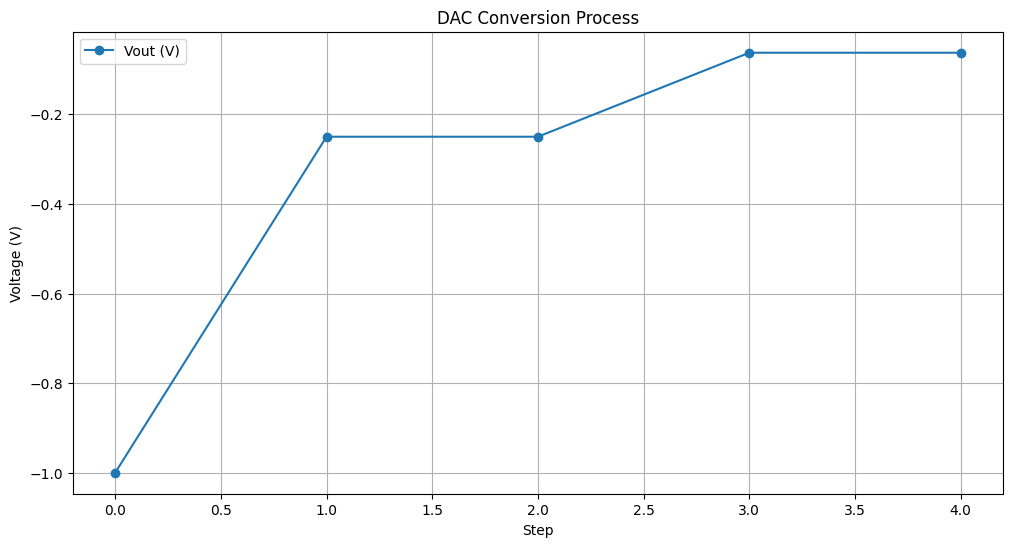

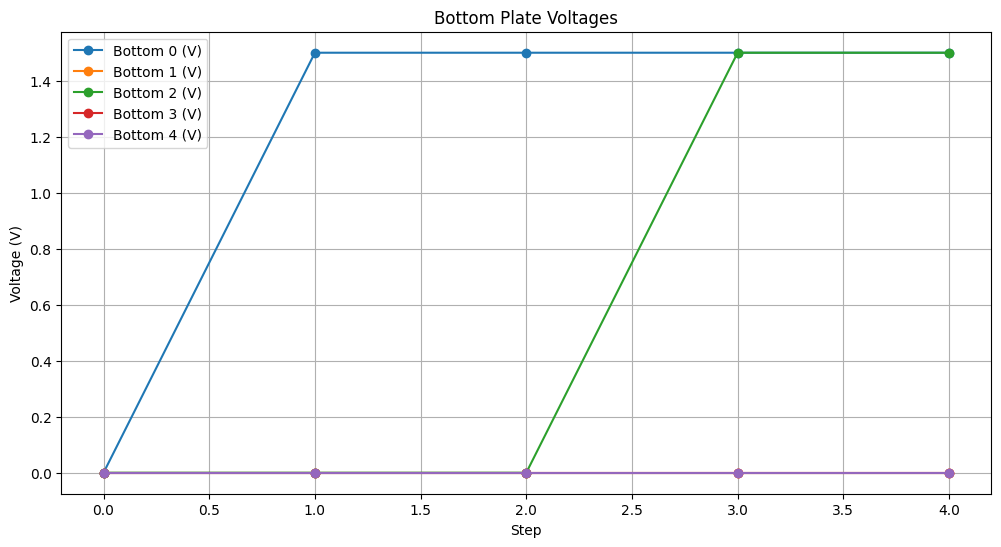

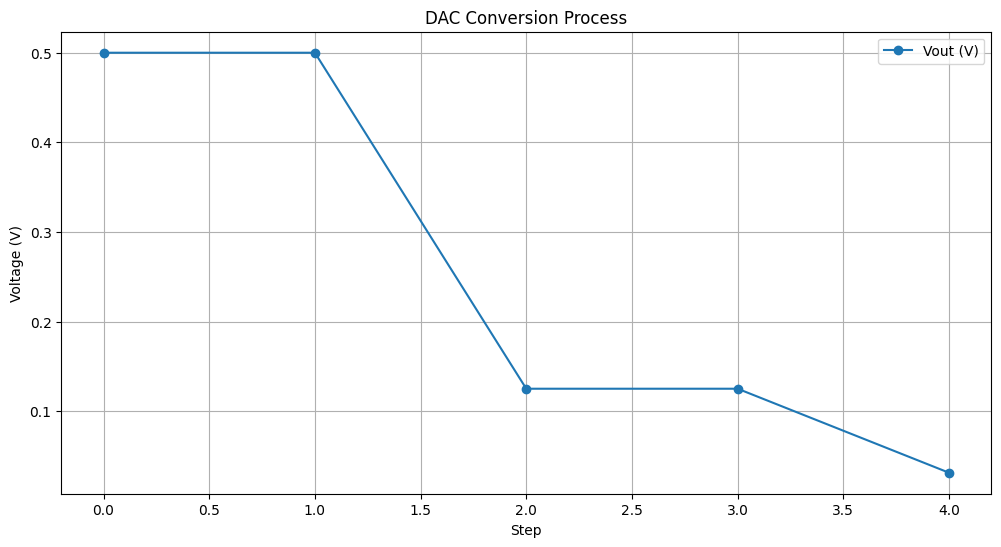

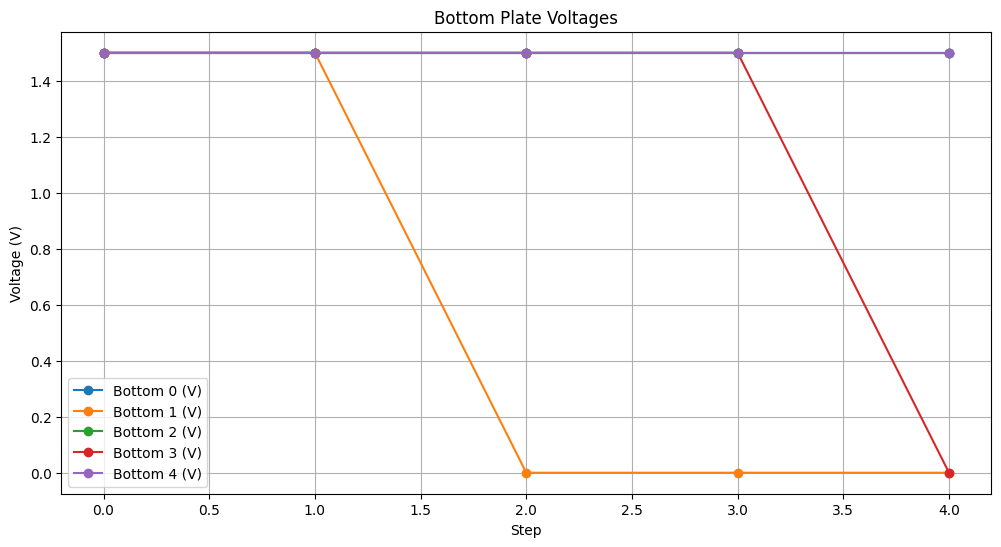

In [200]:
def plot_dac_conversion(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['Step'], df['Vout (V)'], marker='o', label='Vout (V)')
    plt.title('DAC Conversion Process')
    plt.xlabel('Step')
    plt.ylabel('Voltage (V)')
    plt.grid()
    plt.legend()
    plt.show()

    # Show the bottom plate voltages
    bottom_voltages_df = df['Bottom Voltages'].str.split(',', expand=True).astype(float)
    plt.figure(figsize=(12, 6))
    for i in range(len(bottom_voltages_df.columns)):
        plt.plot(df['Step'], bottom_voltages_df[i], marker='o', label=f'Bottom {i} (V)')
    plt.title('Bottom Plate Voltages')
    plt.xlabel('Step')
    plt.ylabel('Voltage (V)')
    plt.grid()
    plt.legend()
    plt.show()

plot_dac_conversion(df_std)
plot_dac_conversion(df_mono)